In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchinfo import summary
import matplotlib.pyplot as plt

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.FashionMNIST(root = "./data", train = True, download = True, transform = tensor_transform)
loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 32, shuffle = True)

testset = datasets.FashionMNIST(root = "./data", train = False, download = True, transform = tensor_transform)
testloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1000, shuffle = False)

In [10]:
print("Cuda available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cuda available: False


In [3]:
img = dataset.data[0]
print("Test set shape:", dataset.data.shape)
print("img shape", img.shape)
torch.Size

input_shape = 28*28
latent_dim = 128

Test set shape: torch.Size([60000, 28, 28])
img shape torch.Size([28, 28])


## MLP

In [267]:
class AESimple(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # YOUR CODE

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=input_shape, out_features=self.latent_dim),
            torch.nn.ReLU()
        )

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.latent_dim, out_features=input_shape),
            torch.nn.Sigmoid()
        )
        
        # YOUR CODE
  
    def forward(self, x):
        # YOUR CODE

        z = self.encoder(x)
        decoded = self.decoder(z)
        reshaped = torch.reshape(decoded, (-1, 1, 28, 28))
        return reshaped
        # YOUR CODE


In [268]:
def train_eval(epochs, lr, model, loader, testloader):
    pelosses = []
    pelosses_test = []

    model = model.to(device)
    loss_function = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) #, weight_decay = 1e-8)

    for epoch in range(epochs):    
        peloss = 0.0
        for (image, _) in loader:
            image = image.to(device)
            reconstructed = model(image)
            loss = loss_function(reconstructed, image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            peloss += loss.item()
        peloss /= len(loader)
        pelosses.append(peloss)
    
        pelosstest = 0.0
        with torch.no_grad():
            for (image,_) in testloader:
                image = image.to(device)
                reconstructed = model(image)  
                pelosstest += loss_function(reconstructed, image).item()
            pelosstest /= len(testloader)
            pelosses_test.append(pelosstest)
        print("Epoch %i: %6.4f  %6.4f"%(epoch,peloss,pelosstest))
    return pelosses, pelosses_test

In [4]:
def plot_loss(pelosses, pelosses_test):
    plt.style.use('fivethirtyeight')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    epochs = len(pelosses)
    plt.semilogy(torch.arange(epochs)+1, pelosses, 'b-')
    plt.semilogy(torch.arange(epochs)+1, pelosses_test, 'r-')

Layer (type:depth-idx)                   Output Shape              Param #
AESimple                                 --                        --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 128]                  100,480
│    └─ReLU: 2-3                         [1, 128]                  --
├─Sequential: 1-2                        [1, 784]                  --
│    └─Linear: 2-4                       [1, 784]                  101,136
│    └─Sigmoid: 2-5                      [1, 784]                  --
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.81
Estimated Total Size (MB): 0.82
Epoch 0: 0.0222  0.0121
Epoch 1: 0.0105  0.0094
Epoch 2: 0.0088  0.0084


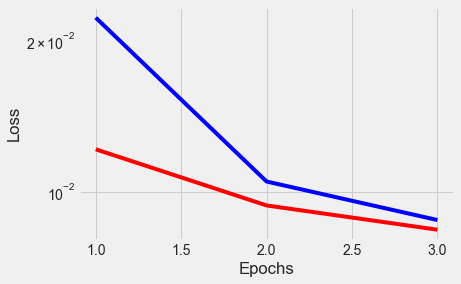

In [270]:
nepochs = 3
model = AESimple(128)
print(summary(model, (1,28,28)))
pelosses, pelosses_test = train_eval(nepochs, 0.001, model, loader, testloader)
plot_loss(pelosses, pelosses_test)

In [5]:
def reconstruct(img, model):
    img = model(img)
    return img

def plot_img(img, title):
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

def plot_samples(dataset, models):
    n = 10
    m = len(models)
    indices = torch.randint(len(dataset), size=(n,))
    cols, rows = n, m+1
    figure = plt.figure(figsize=(18, (m+1)*2))
    for i in range(n):
        idx = indices[i].item()
        img, label = dataset[idx]
        figure.add_subplot(rows, cols, i+1)
        plot_img(img.numpy(), "")
    
        for j in range(m):
            figure.add_subplot(rows, cols, (j+1)*n+i+1)
            img, label = dataset[idx]
            img = reconstruct(img, models[j].to("cpu")).detach().numpy()
            plot_img(img, "")
    
    plt.show()

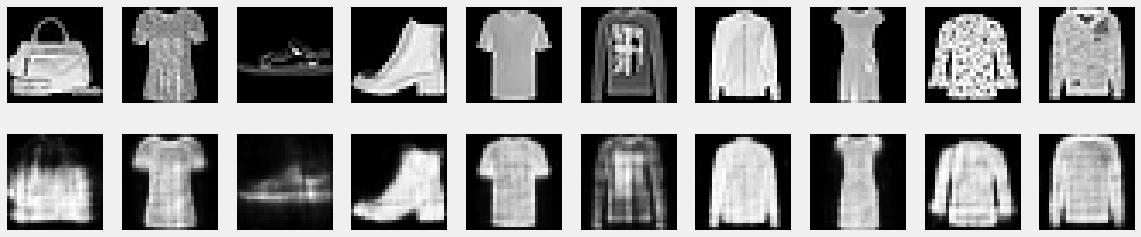

In [272]:
plot_samples(testset, [model])

In [6]:
def interpolate(img1, img2, model, d):
    n = 20
    lrow = int(n/2)
    
    model = model.to("cpu")

    img1 = img1.view(-1,1,28*28)
    z1 = model.encoder(img1)
    
    z1 = z1.view(-1,d)
    rec1 = model.decoder(z1)
    img2 = img2.view(-1,28*28)
    z2 = model.encoder(img2)
    z2 = z2.view(-1,d)
    rec2 = model.decoder(z2)
    
    imgs = [img1.detach().numpy(), rec1.detach().numpy()]
    for i in range(n-4):
        z = z1 + (z2-z1)*i/(n-4)
        img_dist = model.decoder(z).detach().numpy()
        imgs.append(img_dist)

    imgs.append(rec2.detach().numpy())
    imgs.append(img2.detach().numpy())

    plt.figure(figsize=(18, 4))
    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1)
        plot_img(imgs[i].reshape(28,28), "")
    
    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1 + lrow)
        plot_img(imgs[lrow+i].reshape(28,28), "")

plt.show()

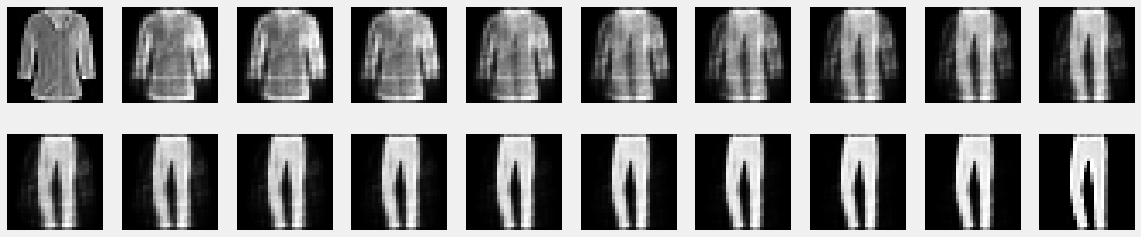

In [274]:
interpolate(testset[4][0], testset[2][0], model, 128)

In [275]:
def noise_added(inputs, model, sigma=0.2):
    n = 10
    m = len(inputs)
    to_plot = {}
    model = model.to("cpu")
    for j in range(m):
        img = inputs[j]
        z = model.encoder(img)
        rec = model.decoder(z)    
        imgs = [img.detach().numpy(), rec.detach().numpy()]
        for i in range(n-2):
            noise = sigma*torch.randn((model.latent_dim,))
            img_dist = model.decoder(z+noise).detach().numpy()
            imgs.append(img_dist)        
        to_plot[j] = imgs
        
    plt.figure(figsize=(20, m*2))
    ax = plt.subplot(m, n, 1)
    for j in range(m):
        for i in range(n):
            ax = plt.subplot(m, n, j*n+i+1)
            plot_img(to_plot[j][i].reshape(28,28), "")
        
    plt.show()

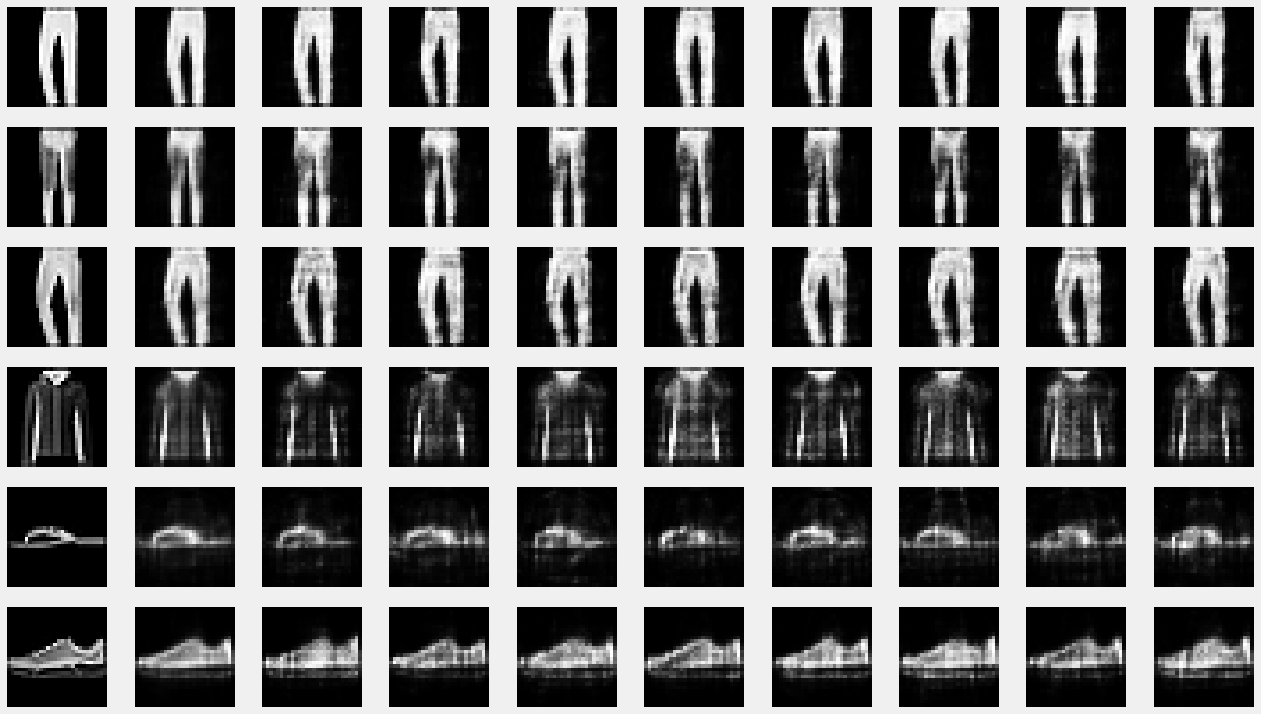

In [276]:
noise_added([testset[i][0] for i in [2,3,5,6,8,9]], model, sigma=0.5)

In [277]:
def generated(model, ld=None):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    d = model.latent_dim if hasattr(model,"latent_dim") else ld
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((d,)).view(-1,d)
            rec = model.decoder(z).detach().numpy()        
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")
        
    plt.show()

In [278]:
def generated4cnn(model, ld=None):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    d = model.latent_dim if hasattr(model,"latent_dim") else ld
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((d,)).view(-1,d)
            rec = model.decoder(z).detach().numpy()
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")

    plt.show()

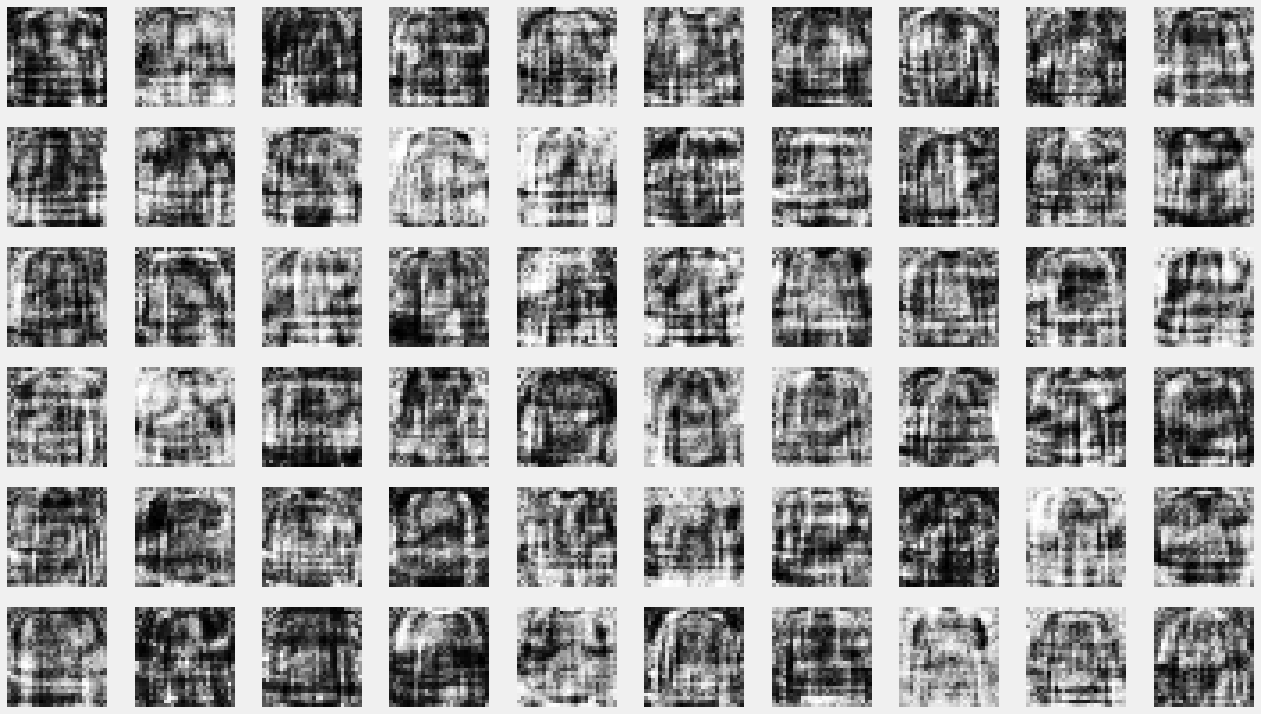

In [279]:
generated(model)

## CNN

In [280]:
class AECNN1(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # YOUR CODE

        ## // -> integer division -> 10 // 3 = 3
        self.latent_dim = latent_dim
        self.d = latent_dim // 4

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=4),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=self.latent_dim, kernel_size=3, stride=2),
            torch.nn.Flatten()
        )


        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=self.d, out_channels=64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5, stride=1),
            torch.nn.Sigmoid()
        )
        
        # YOUR CODE
  
    def forward(self, x):
        # YOUR CODE
        # print("shape x before:", x.shape)
        x = x.view(-1, 1, 28, 28)
        # print("shape x after:", x.shape)
        z = self.encoder(x)

        # print("shape z before:", z.shape)

        z = z.view(-1, self.d, 2, 2)

        # print("shape z after:", z.shape)

        reconstructed = self.decoder(z)

        return reconstructed
        
        # YOUR CODE


In [281]:
epochs = 3
lr = 0.001
model = AECNN1(128)

print(summary(model))

pelosses2, pelosses_test2 = train_eval(epochs, lr, model, loader, testloader)

Layer (type:depth-idx)                   Param #
AECNN1                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       416
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       8,224
│    └─ReLU: 2-4                         --
│    └─Conv2d: 2-5                       18,496
│    └─ReLU: 2-6                         --
│    └─Conv2d: 2-7                       73,856
│    └─Flatten: 2-8                      --
├─Sequential: 1-2                        --
│    └─ConvTranspose2d: 2-9              18,496
│    └─ReLU: 2-10                        --
│    └─ConvTranspose2d: 2-11             18,464
│    └─ReLU: 2-12                        --
│    └─ConvTranspose2d: 2-13             8,208
│    └─ReLU: 2-14                        --
│    └─ConvTranspose2d: 2-15             401
│    └─Sigmoid: 2-16                     --
Total params: 146,561
Trainable params: 146,561
Non-trainable params: 0
Epoch 0: 0.0198  0.

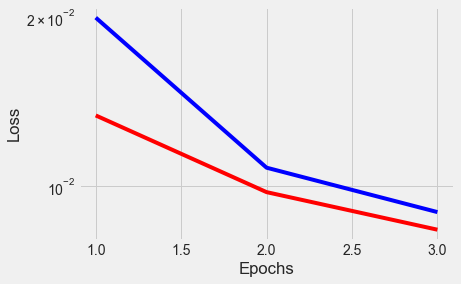

In [283]:
plot_loss(pelosses2, pelosses_test2)

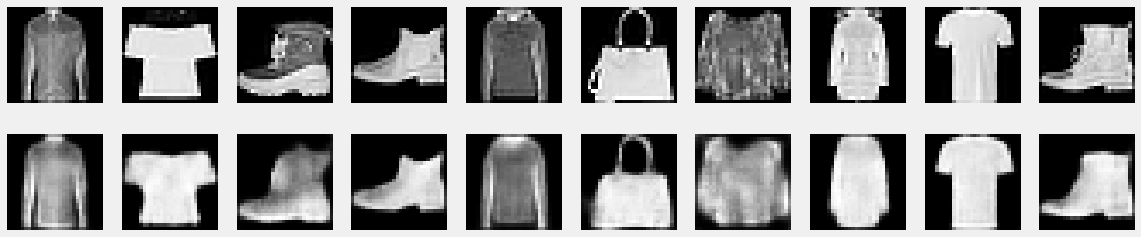

In [284]:
plot_samples(testset, [model])

In [285]:
def generated4cnn(model, ld=None):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    d = model.latent_dim if hasattr(model, "latent_dim") else ld
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((1, d//4, 2, 2))
            rec = model.decoder(z).detach().numpy()
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")

    plt.show()

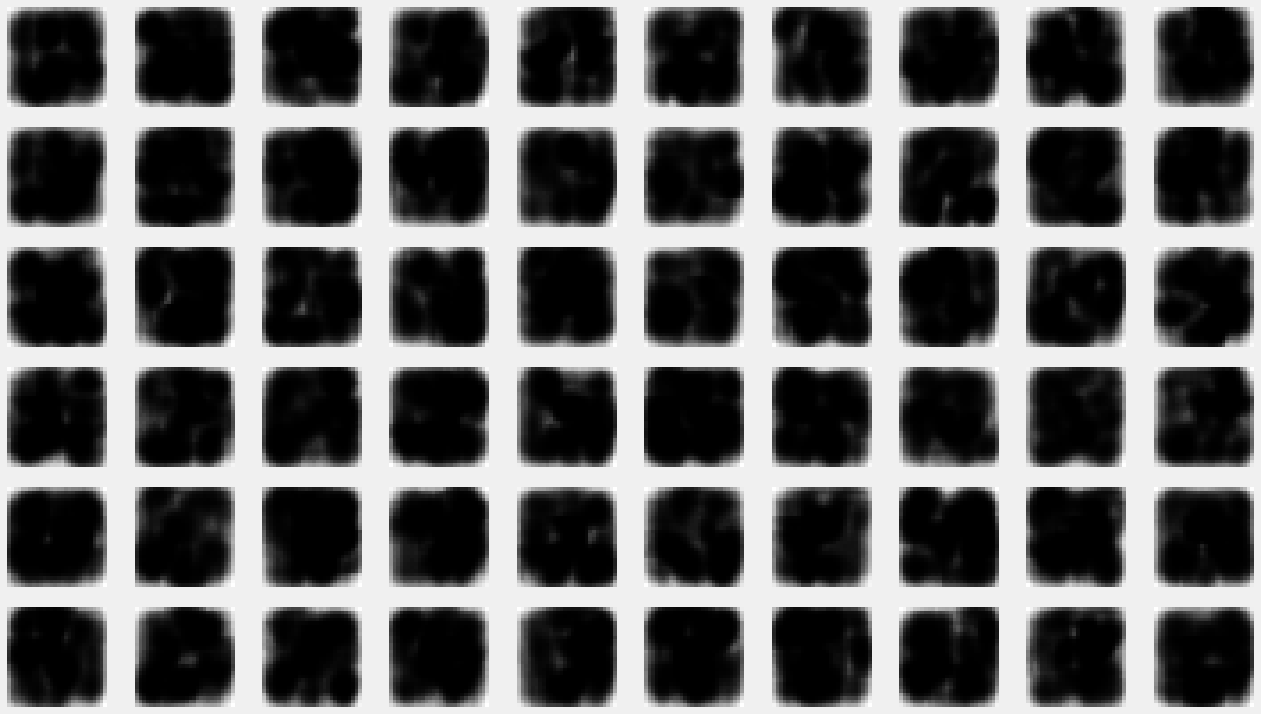

In [286]:
generated4cnn(model, 128)

What model leads to the best (smallest) reconstruction error on the test set ? Verify that also by looking at individual samples from the (test) set.

Both auto-encoders (fully-connected and CNNs) lead to equivalent reconstruction losses.

Fully-connected:
Epoch 0: 0.0222  0.0121
Epoch 1: 0.0105  0.0094
Epoch 2: 0.0088  0.0084

CNN:
Epoch 0: 0.0198  0.0124
Epoch 1: 0.0108  0.0096
Epoch 2: 0.0090  0.0088

The models achieve quite passable reconstruction images. For some clothing items they have more trouble with the reconstruction, e.g. shoes and bags. The cnn can achieve slightly better results than the fully constituted autoencoder.

Interestingly, the generated patterns look completely different.


## VAE

In [19]:
class VAECNN2(torch.nn.Module): 
    def __init__(self, latent_dim, beta=1.0):
        super().__init__()

        ## // -> integer division -> 10 // 3 = 3
        self.latent_dim = latent_dim
        self.d = latent_dim // 4
        self.beta = beta

        self.kl = 0

        self.N: torch.distributions.Normal = torch.distributions.Normal(0, 1)

        self.reconstruction_loss_function = torch.nn.MSELoss().to(device)

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=self.d, kernel_size=3, stride=2, padding=0),
            torch.nn.ReLU(),
            # torch.nn.Conv2d(in_channels=64, out_channels=self.latent_dim, kernel_size=3, stride=2),
            # torch.nn.ReLU(),
            torch.nn.Flatten(start_dim=1),
            torch.nn.Linear(in_features=3*3*self.d, out_features=self.latent_dim)
        )

        self.linear_mu = torch.nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)
        self.linear_var = torch.nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim)


        # # Decoder
        self.decoder_linear = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, self.latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.latent_dim, 3 * 3 * self.d)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Unflatten(dim=1, unflattened_size=(self.d, 3, 3)),
            torch.nn.ConvTranspose2d(in_channels=self.d, out_channels=16, stride=2, kernel_size=3, output_padding=0),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid()
        )

        
    def encode(self, x):

        encoded = self.encoder(x)

        mu = self.linear_mu(encoded)
        sigma = self.linear_var(encoded)

        return [mu, sigma]
        
        # YOUR CODE


    def decode(self, z):

        z = self.decoder_linear(z)
        decoded = self.decoder(z)

        return decoded

    def reparameterize(self, mu, sigma):
        e = self.N.sample(mu.shape)
        z = mu + sigma * e
        return z
  
    def forward(self, x):
        # YOUR CODE
        mu, sigma = self.encode(x)

        z = self.reparameterize(mu, sigma)

        decoded = self.decode(z)

        return [decoded, x, mu, sigma]

        
        # YOUR CODE
    
    def loss(self, img, rec, mu, sigma):
        # YOUR CODE
        # Compute the total loss (per batch): Reconstruction Loss + KL Loss

        reconstruction_loss = self.reconstruction_loss_function(img, rec)

        kl_loss = torch.mean(-0.5 * torch.sum(1+ sigma**2 - mu**2 - (sigma**2).exp(), dim=1), dim=0)
        loss = reconstruction_loss + self.beta * kl_loss

        return [loss, reconstruction_loss, kl_loss]
        
        # YOUR CODE
    
    def reconstruct(self, x):
        # YOUR CODE
        # Just take the mu as z (without sampling)
        # z shape: torch.Size([32, 32, 2, 2])
        x = x.reshape(-1, 1, 28, 28)

        mu, sigma = self.encode(x)

        decoded = self.decode(mu)
        return decoded
        
        # YOUR CODE


In [7]:
def train_eval_vae(epochs, lr, model, loader, testloader, decay_lr=0.9):
    pelosses = []
    pelosses_rec = []
    pelosses_kl = []
    pelosses_test = []
    pelosses_test_rec = []
    pelosses_test_kl = []

    model = model.to(device)
    loss_function = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) #, weight_decay = 1e-8)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_lr)
    
    for epoch in range(epochs):    
        peloss = 0.0
        peloss_rec = 0.0
        peloss_kl = 0.0
        for (image, _) in loader:
            image = image.to(device)
            reconstructed, x, mu, sigma  = model(image)
            loss, recloss, klloss = model.loss(reconstructed, image, mu, sigma)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            peloss += loss.item()
            peloss_rec += recloss.item()
            peloss_kl += klloss.item()
        peloss /= len(loader)
        peloss_rec /= len(loader)
        peloss_kl /= len(loader)
        pelosses.append(peloss)
        pelosses_rec.append(peloss_rec)
        pelosses_kl.append(peloss_kl)
        
        scheduler.step()
    
        testpeloss = 0.0
        testpeloss_rec = 0.0
        testpeloss_kl = 0.0
        with torch.no_grad():
            for (image,_) in testloader:
                image = image.to(device)
                reconstructed, x, mu, sigma = model(image)
                loss, recloss, klloss = model.loss(reconstructed, image, mu, sigma)
                testpeloss += loss.item()
                testpeloss_rec += recloss.item()
                testpeloss_kl += klloss.item()
            testpeloss /= len(testloader)
            testpeloss_rec /= len(testloader)
            testpeloss_kl /= len(testloader)
            pelosses_test.append(testpeloss)
            pelosses_test_rec.append(testpeloss_rec)
            pelosses_test_kl.append(testpeloss_kl)
        print("Epoch %i: %6.4f  %6.4f %6.4f %6.4f %6.4f %6.4f"%(epoch, peloss, peloss_rec, peloss_kl, testpeloss, testpeloss_rec, testpeloss_kl))
    return pelosses, pelosses_rec, pelosses_kl, pelosses_test, pelosses_test_rec, pelosses_test_kl

In [20]:
epochs = 3
lr = 0.001
vae = VAECNN2(1024, 0.1)

print(summary(vae))

pelosses, pelosses_rec, pelosses_kl, pelosses_test, pelosses_test_rec, pelosses_test_kl \
    = train_eval_vae(epochs, lr, vae, loader, testloader,decay_lr=1.0)

Layer (type:depth-idx)                   Param #
VAECNN2                                  --
├─MSELoss: 1-1                           --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-1                       80
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       1,168
│    └─BatchNorm2d: 2-4                  32
│    └─ReLU: 2-5                         --
│    └─Conv2d: 2-6                       37,120
│    └─ReLU: 2-7                         --
│    └─Flatten: 2-8                      --
│    └─Linear: 2-9                       2,360,320
├─Linear: 1-3                            1,049,600
├─Linear: 1-4                            1,049,600
├─Sequential: 1-5                        --
│    └─Linear: 2-10                      1,049,600
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      2,361,600
├─Sequential: 1-6                        --
│    └─Unflatten: 2-13                   --
│    └─ConvTranspose2d: 2-14 

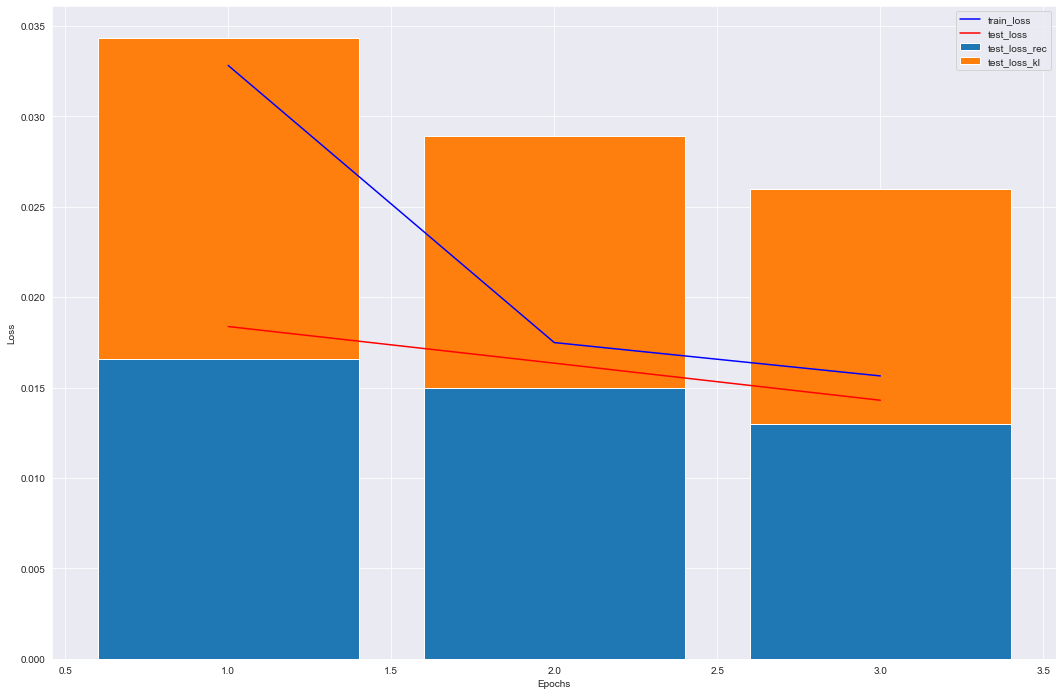

In [13]:
plt.figure(figsize=(18,12))
plt.xlabel('Epochs')
plt.ylabel('Loss')
epochs = len(pelosses)
plt.plot(torch.arange(epochs)+1, pelosses, 'b-', label="train_loss")
plt.plot(torch.arange(epochs)+1, pelosses_test, 'r-',label="test_loss")    
plt.bar(torch.arange(epochs)+1, pelosses_test_rec, label="test_loss_rec")
plt.bar(torch.arange(epochs)+1, pelosses_test_kl, bottom=pelosses_test_rec, label="test_loss_kl")
plt.legend()

In [14]:
def plot_samples_vae(dataset, model: VAECNN2):
    n = 10
    m = 1
    model.to("cpu")
    indices = torch.randint(len(dataset), size=(n,))
    cols, rows = n, m+1
    figure = plt.figure(figsize=(18, (m+1)*2))
    for i in range(n):
        idx = indices[i].item()
        img, label = dataset[idx]
        figure.add_subplot(rows, cols, i+1)
        plot_img(img.numpy(), "")
    
        figure.add_subplot(rows, cols, n+i+1)
        img, label = dataset[idx]
        img = model.reconstruct(img).detach().numpy()
        plot_img(img, "")    
    plt.show()

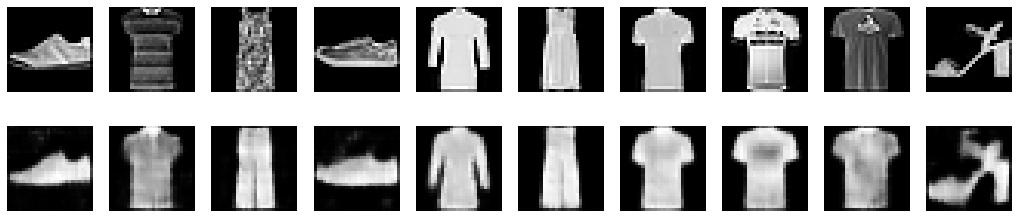

In [15]:
plot_samples_vae(testset, vae)

In [16]:
# z shape: torch.Size([32, 32, 2, 2])

def generated(model):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((model.latent_dim,)).view(-1, model.latent_dim)
            rec = model.decode(z).detach().numpy()
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")
        
    plt.show()

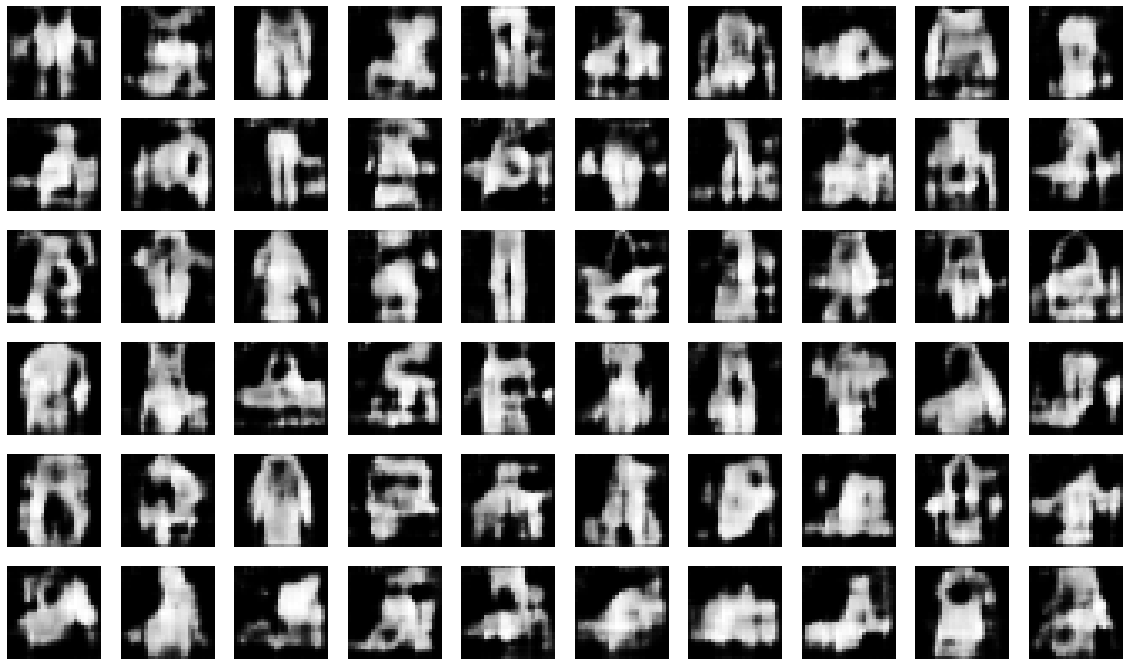

In [18]:
generated(vae)

Transform your CNN-only AE from the previous subsection into a VAE, again using 128 latent dimensions. During training track both, the reconstruction error and the KL-loss. Could you improve the reconstruction error by when comparing with the plain autoencoder?

Yes, by using CNN we were able to improve the reconstruction error and the KL-Loss compared to the previous models.

Epoch 0: 0.0337  0.0292 0.0451 0.0207 0.0190 0.0171
Epoch 1: 0.0195  0.0179 0.0157 0.0180 0.0165 0.0151
Epoch 2: 0.0173  0.0158 0.0144 0.0162 0.0148 0.0136

The regenerated images are slightly better than those of the predecessors. But they still contain some blur.


Explore the latent space of the trained VAE - following the same steps as above. Describe and judge/interpret of what you observe. How does the random generation by sampling from the
latent space work now?

In some images generated by sampling from the latent space cloths can be recognized. But overall the resulting images are not qualitatively meaningfull.

We tried different models and different hyperparameters as well as adjustments in the loss function. Still, the images did not improve significantly.

We wonder if the problem is related to our wrong implementation or if it is difficult to achieve better performance with our CNN architecture.